imports and uploads
-----------

In [18]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tqdm.auto import tqdm
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter('ignore')
from scipy import stats
import os
%matplotlib inline

In [19]:
# upload data
cpath = os.getcwd() #assumes scalar_df_females is in the same path as the notebook
scalar_df = pd.read_csv(cpath+'/scalar_df_female.csv')
scalar_df_subset=scalar_df.copy()

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [20]:
# plot/colors definitions
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use("seaborn-paper")
phasec = ['#CE3045','#EF7C32','#FFDD00','#939598']

## Calculate coefficient of variation of syllable usage within a session

In [21]:
def stride_window(a, w = 4, o = 2, copy = False):
    sh = (a.size - w + 1, w)
    st = a.strides * 2
    view = np.lib.stride_tricks.as_strided(a, strides = st, shape = sh)[0::(w-o-1)]
    if copy:
        return view.copy()
    else:
        return view[:, [0, -1]]
    
def compute_recording_duration(ser):
    return ((ser - ser.min()) / 1000 / 60).max()

In [22]:
syll_counts = scalar_df.loc[scalar_df['onset'], 'labels (usage sort)'].value_counts(normalize=True)
keep = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
          10,11,12,13,14,15,16,17,18,19,
          20,21,22,23,24,25,26,27,28,29,
          30,31,32,33,34,35,36,37,38,39,
          40,41,42,43,44,45,46,47,49] # syllable 49 is refered to in the manuscript and mean_df_female as 48 for clarity
scalar_df.groupby('uuid')['timestamps'].apply(compute_recording_duration).sort_values()
scalar_df['time_sec'] = scalar_df.groupby('uuid')['timestamps'].apply(lambda v: (v - v.min()) / 1000)
sliding = stride_window(np.arange(0, 21 * 60), w=5 * 60, o=int(2.5 * 60))

In [23]:
within_session_usage_cv = {}
for uuid, session_df in tqdm(scalar_df[scalar_df['onset']].groupby('uuid', sort=False)):
    usages = []
    for start, stop in sliding:
        usages.append(session_df.query('time_sec >= @start & time_sec < @stop')['labels (usage sort)'].value_counts().reindex(np.arange(len(keep))))
    usages = pd.DataFrame(usages, index=np.arange(len(usages)))
    within_session_usage_cv[uuid] = usages.std() / usages.mean()

  0%|          | 0/200 [00:00<?, ?it/s]

In [24]:
cd=[]
cdb=[]
cde=[]
cdm=[]
groups = sorted(scalar_df.group.unique())
for i,gp in enumerate(groups):
    uuidss = scalar_df.uuid[scalar_df.group==gp].unique()
    c=[]
    for i,curr_uuid in enumerate(uuidss):
        curr_cv=within_session_usage_cv[curr_uuid] # get cv for current session
        c.append(curr_cv)
    cd.append(np.array(c))
    cdm.append(np.nanmean(np.array(c), axis=0))

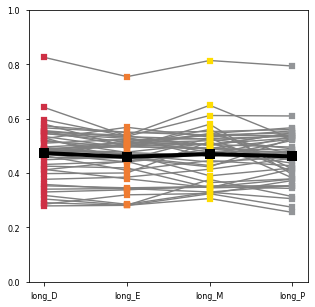

In [25]:
#plot
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
plt.plot(groups, cdm, 
         mec=None, color='grey',ms=3, zorder=-1)
for c, g in zip(phasec, cdm):
    plt.scatter([phasec.index(c)] * len(g), g, color=c, marker='s')
plt.errorbar(groups, np.nanmean(cdm, axis=1), stats.sem(cdm, axis=1,nan_policy= 'omit'),
             marker='s', mfc='black',mec=None, lw=4, ms=10,color='black')
ax.set_ylim([0,1])
fig.savefig(data_loc +'cv_syllable_dynamics_in_session_new.pdf', bbox_inches='tight')

In [26]:
#statistics
stats.friedmanchisquare(cdm[0],cdm[1],cdm[2],cdm[3])

FriedmanchisquareResult(statistic=4.028571428571354, pvalue=0.25839541380537334)